# Automatic Sleep Stages Classification

Sasha Collin, Clément Nguyen

April 1st, 2021

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

#from scripts.utils import DataLoader, j_means, features_relevance_analysis, features_relevance_analysis_2, best_cluster_assignment
from scripts.utils import *
from scripts.features import fractal_dimension, dfa, shannon_entropy, fast_sampen_apen, multiscale_entropy
from scripts.atoms import *

## Load EEG data

In [ ]:
data_path = 'data'
dataloader = DataLoader(path=data_path)

for data in dataloader.get_data():
    
    id, night, labels = data['id'], data['night'], data['labels']
    
    eeg_fpz = data['data'][:,0,:]
    eeg_pz = data['data'][:,1,:]
    
# Normalize data
eeg_fpz_mean, eeg_fpz_std = eeg_fpz.reshape(-1).mean(), eeg_fpz.reshape(-1).std()
eeg_pz_mean, eeg_pz_std = eeg_pz.reshape(-1).mean(), eeg_pz.reshape(-1).std()
eeg_fpz = (eeg_fpz - eeg_fpz_mean)/eeg_fpz_std
eeg_pz = (eeg_pz - eeg_pz_mean)/eeg_pz_std

num_epochs = eeg_fpz.shape[0]

## Compute entropy features

In [3]:
features_path = os.path.join(data_path, 'features_18_2.csv') # path to pre-computed features
load_features = os.path.exists(features_path)
save_features = False

entropy_features = [
    'FD-Fpz','FD-Pz','HFD-Fpz','HFD-Pz','KFD-Fpz','KFD-Pz', # fractal dimension
    'DFA-a1-Fpz','DFA-a2-Fpz','DFA-a1-Pz','DFA-a2-Pz', # DFA
    'H-Fpz','H-Pz', # shannon entropy
    'ApEn-m1-Fpz','ApEn-m2-Fpz','ApEn-m1-Pz','ApEn-m2-Pz', # approximate entropy
    'SampEn-m1-Fpz','SampEn-m2-Fpz','SampEn-m1-Pz','SampEn-m2-Pz',# sample entropy 
    'MSE-tau2-Fpz','MSE-tau3-Fpz','MSE-tau4-Fpz','MSE-tau5-Fpz','MSE-tau6-Fpz', # multiscale entropy
    'MSE-tau2-Pz','MSE-tau3-Pz','MSE-tau4-Pz','MSE-tau5-Pz','MSE-tau6-Pz'
]

In [4]:
if load_features:
    print('Pre-computed features found. Loading features.')
    features = pd.read_csv(features_path)

else: # takes some time to compute features
    print('Pre-computed features not found. Computing features.')
    features = {}
    features['id'] = [id for k in range(num_epochs)]
    features['night'] = [night for k in range(num_epochs)]
    features['label'] = list(labels)
    for ft in entropy_features: 
        features[ft] = []

    for i in tqdm(range(num_epochs)):

        eeg_fpz_i = eeg_fpz[i]
        eeg_pz_i = eeg_pz[i]

        # Fractal dimension 
        features['FD-Fpz'].append(fractal_dimension(eeg_fpz_i))
        features['FD-Pz'].append(fractal_dimension(eeg_pz_i))

        features['HFD-Fpz'].append(higuchi_fractal_dimension(eeg_fpz_i))
        features['HFD-Pz'].append(higuchi_fractal_dimension(eeg_pz_i))

        features['KFD-Fpz'].append(katz_fractal_dimension(eeg_fpz_i))
        features['KFD-Pz'].append(katz_fractal_dimension(eeg_pz_i))

        # Detrended Fluctuation Analysis
        features['DFA-a1-Fpz'].append(dfa(eeg_fpz_i, 4, 16))
        features['DFA-a2-Fpz'].append(dfa(eeg_fpz_i, 16, 64))
        features['DFA-a1-Pz'].append(dfa(eeg_pz_i, 4, 16))
        features['DFA-a2-Pz'].append(dfa(eeg_pz_i, 16, 64))

        # Shannon Entropy
        features['H-Fpz'].append(shannon_entropy(eeg_fpz_i))
        features['H-Pz'].append(shannon_entropy(eeg_pz_i))

        # Approximate Entropy & Sample Entropy
        sampen, apen = fast_sampen_apen(eeg_fpz_i, 3)
        features['ApEn-m1-Fpz'].append(apen[0])
        features['ApEn-m2-Fpz'].append(apen[1])
        features['SampEn-m1-Fpz'].append(sampen[0])
        features['SampEn-m2-Fpz'].append(sampen[1])

        sampen, apen = fast_sampen_apen(eeg_pz_i, 3)
        features['ApEn-m1-Pz'].append(apen[0])
        features['ApEn-m2-Pz'].append(apen[1])
        features['SampEn-m1-Pz'].append(sampen[0])
        features['SampEn-m2-Pz'].append(sampen[1])

        # Multiscale Entropy
        taus = [2,3,4,5,6]
        for tau in taus:
            features['MSE-tau{}-Fpz'.format(tau)].append(multiscale_entropy(eeg_fpz_i, 2, tau))
            features['MSE-tau{}-Pz'.format(tau)].append(multiscale_entropy(eeg_pz_i, 2, tau))

    features = pd.DataFrame.from_dict(features)
    features[entropy_features] = features[entropy_features].astype('float32')
    features[['id', 'night', 'label']] = features[['id', 'night', 'label']].astype('int8')
    
    if save_features:
        df.to_csv(features_path, index=False)

Pre-computed features found. Loading features.


In [5]:
subjects, nepochs = np.unique(features[['id','night']].to_numpy(), return_counts=True, axis=0)

## Feature relevance analysis

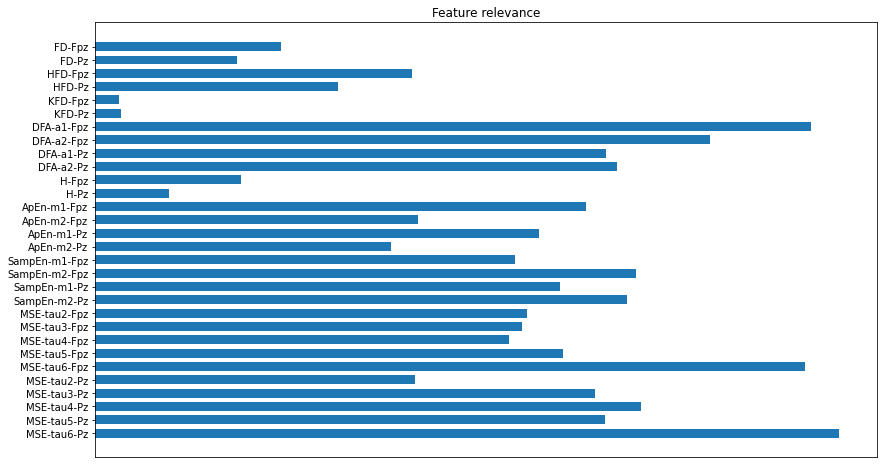

In [6]:
# Compute feature weights

feature_weights = np.zeros((subjects.shape[0], len(entropy_features)))
for i, (id, night) in enumerate(subjects):
    subject_features = features[(features['id']==id) & (features['night']==night)]
    X = subject_features[entropy_features].to_numpy()
    feature_weights[i] = features_relevance_analysis_2(X)[1]
feature_weights = feature_weights.mean(axis=0)


# Plot feature relevance

plt.figure(figsize = (14,8))
plt.barh([3*i for i in range(len(entropy_features))], feature_weights[::-1], tick_label=entropy_features[::-1], height=2)
plt.xticks([])
plt.title('Feature relevance')
plt.show()

In [7]:
num_relevant_features = 8
relevant_features = np.argsort(feature_weights)[::-1]
relevant_features = [entropy_features[relevant_features[idx]] for idx in relevant_features[:num_relevant_features]]
print('Most relevant features : ', relevant_features)

Most relevant features :  ['KFD-Fpz', 'SampEn-m2-Pz', 'FD-Fpz', 'DFA-a2-Pz', 'H-Pz', 'SampEn-m1-Fpz', 'ApEn-m2-Fpz', 'MSE-tau5-Pz']


## Clustering

In [8]:
results = []

for i, (id, night) in enumerate(subjects):
    
    print('ID : {} | Night {}'.format(id, night))    

    subject_features = features[(features['id']==id) & (features['night']==night)]

    y = subject_features.label.to_numpy()
    X_all = subject_features[entropy_features].to_numpy()
    X_relevant = subject_features[relevant_features].to_numpy()
    X_projected, _ = features_relevance_analysis(X_all, variance_criterion=0.98)
    
    tmp_res = []
    
    for X in [X_relevant, X_projected]: 
        scores = {}
        
        # J-means
        pred, centroids = j_means(X, n_clusters=5, random_init=False)
        cluster_to_label = best_cluster_assignment(y, pred)
        pred_label = [cluster_to_label[cluster] for cluster in pred]

        scores['jmeans'] = {
            'accuracy': accuracy_score(y, pred_label),
            'precision': precision_score(y, pred_label, average=None),
            'avg_precision': precision_score(y, pred_label, average='macro'),
            'recall': recall_score(y, pred_label, average=None),
            'avg_recall': recall_score(y, pred_label, average='macro')
        }
        
        # K-means
        kmeans = KMeans(n_clusters=5)
        pred = kmeans.fit_predict(X)
        cluster_to_label = best_cluster_assignment(y, pred)
        pred_label = [cluster_to_label[cluster] for cluster in pred]

        scores['kmeans'] = {
            'accuracy': accuracy_score(y, pred_label),
            'precision': precision_score(y, pred_label, average=None),
            'avg_precision': precision_score(y, pred_label, average='macro'),
            'recall': recall_score(y, pred_label, average=None),
            'avg_recall': recall_score(y, pred_label, average='macro')
        }
        
        tmp_res.append(scores)
    results.append(tmp_res)

ID : 18 | Night 2
Looking for possible jumps | it  1  | value :  104



Looking for possible jumps | it  1  | value :  20


Jump found | old: 20.881926552955363 | new 20.88187312493853
Jump found | old: 20.88187312493853 | new 20.88186042068632
Jump found | old: 20.88186042068632 | new 20.881716446758393

Looking for possible jumps | it  2  | value :  20


## Results

### J-means

In [9]:
# J-means accuracy
print('{:<20} {:>10} {:>20} {:>20}'.format('','Accuracy', 'Average precision', 'Average recall'))
print('{:<20} {:>10} {:>20} {:>20}'.format('Relevant features',
                                           np.round(np.mean([res[0]['jmeans']['accuracy'] for res in results]),4),
                                           np.round(np.mean([res[0]['jmeans']['avg_precision'] for res in results]),4),
                                           np.round(np.mean([res[0]['jmeans']['avg_recall'] for res in results]),4)))
print('{:<20} {:>10} {:>20} {:>20}'.format('Projected features',
                                           np.round(np.mean([res[1]['jmeans']['accuracy'] for res in results]),4),
                                           np.round(np.mean([res[1]['jmeans']['avg_precision'] for res in results]),4),
                                           np.round(np.mean([res[1]['jmeans']['avg_recall'] for res in results]),4)))

                       Accuracy    Average precision       Average recall
Relevant features         0.688               0.7026               0.6826
Projected features       0.6424               0.6649               0.6495


### K-means

In [10]:
# K-means accuracy
print('{:<20} {:>10} {:>20} {:>20}'.format('','Accuracy', 'Average precision', 'Average recall'))
print('{:<20} {:>10} {:>20} {:>20}'.format('Relevant features',
                                           np.round(np.mean([res[0]['kmeans']['accuracy'] for res in results]),4),
                                           np.round(np.mean([res[0]['kmeans']['avg_precision'] for res in results]),4),
                                           np.round(np.mean([res[0]['kmeans']['avg_recall'] for res in results]),4)))
print('{:<20} {:>10} {:>20} {:>20}'.format('Projected features',
                                           np.round(np.mean([res[1]['kmeans']['accuracy'] for res in results]),4),
                                           np.round(np.mean([res[1]['kmeans']['avg_precision'] for res in results]),4),
                                           np.round(np.mean([res[1]['kmeans']['avg_recall'] for res in results]),4)))

                       Accuracy    Average precision       Average recall
Relevant features         0.688                0.705               0.6832
Projected features       0.6435               0.6655               0.6501


### Per stage results

In [11]:
[res[0]['kmeans']['precision'] for res in results]

print('{:<20} {:>10} {:>20}'.format('','Precision', 'Recall'))
for i in range(1,6):
    print('{:<20} {:>10} {:>20}'.format('Sleep stage {}'.format(i),
                                    np.round(np.mean([res[0]['kmeans']['precision'] for res in results], axis=0)[i-1],4),
                                    np.round(np.mean([res[0]['kmeans']['recall'] for res in results], axis=0)[i-1],4),))

                      Precision               Recall
Sleep stage 1               1.0               0.7823
Sleep stage 2            0.5723               0.6556
Sleep stage 3            0.7325               0.5759
Sleep stage 4            0.9147               0.8935
Sleep stage 5            0.3057               0.5086


### Confusion matrix

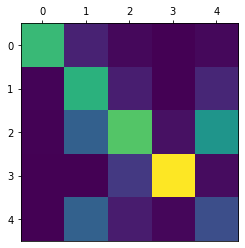

In [12]:
cm = confusion_matrix(y, pred_label, labels=np.arange(1,6))

fig = plt.figure()
axes = plt.gca()
plt.imshow(cm)
axes.xaxis.tick_top()
plt.show()

## Spectral features

#### Load spectral features

In [13]:
spectral_features_path = os.path.join(data_path, 'spectral_features/')

#### Clustering

In [14]:
spect_results = []

for i, (id, night) in enumerate(subjects):
    
    print('ID : {} | Night {}'.format(id, night))    

    subject_features = features[(features['id']==id) & (features['night']==night)]

    y = subject_features.label.to_numpy()
    X_all = np.load(spectral_features_path + '{}_{}.npy'.format(id,night))
    X_relevant, _  = features_relevance_analysis_2(X_all, variance_criterion=0.98)
    X_projected, _ = features_relevance_analysis(X_all, variance_criterion=0.98)
    
    tmp_res = []
    
    for X in [X_all, X_relevant, X_projected]: 
        scores = {}
        
        # K-means
        kmeans = KMeans(n_clusters=5)
        pred = kmeans.fit_predict(X)
        cluster_to_label = best_cluster_assignment(y, pred)
        pred_label = [cluster_to_label[cluster] for cluster in pred]

        scores['kmeans'] = {
            'accuracy': accuracy_score(y, pred_label),
            'precision': precision_score(y, pred_label, average=None),
            'avg_precision': precision_score(y, pred_label, average='macro'),
            'recall': recall_score(y, pred_label, average=None),
            'avg_recall': recall_score(y, pred_label, average='macro')
        }
        
        tmp_res.append(scores)
    spect_results.append(tmp_res)

ID : 18 | Night 2


#### Results

In [15]:
# K-means accuracy
print('{:<20} {:>10} {:>20} {:>20}'.format('','Accuracy', 'Average precision', 'Average recall'))
print('{:<20} {:>10} {:>20} {:>20}'.format('Relevant features',
                                           np.round(np.mean([res[0]['kmeans']['accuracy'] for res in spect_results]),4),
                                           np.round(np.mean([res[0]['kmeans']['avg_precision'] for res in spect_results]),4),
                                           np.round(np.mean([res[0]['kmeans']['avg_recall'] for res in spect_results]),4)))
print('{:<20} {:>10} {:>20} {:>20}'.format('Projected features',
                                           np.round(np.mean([res[1]['kmeans']['accuracy'] for res in spect_results]),4),
                                           np.round(np.mean([res[1]['kmeans']['avg_precision'] for res in spect_results]),4),
                                           np.round(np.mean([res[1]['kmeans']['avg_recall'] for res in spect_results]),4)))

                       Accuracy    Average precision       Average recall
Relevant features        0.7065               0.7405               0.7112
Projected features        0.687               0.7153               0.6816


## Convolutional dictionary learning (CDL)

In [13]:
# notation
sample = data

### A first example of reconstruction

In [14]:
# Parameters to change
n_atoms = 8
atom_length = 200
penalty = 4 #6

# Select a signal
label = 1
signal = get_training_signal(sample, label)

# Random number generator
rng = np.random.RandomState(seed=123)

In [15]:
# Dictionary learning and sparse coding
dict_learning = learn_dict(signal[:,0], atom_length, n_atoms, rng, penalty)

sparse_codes = learn_codes(signal[:,0], dict_learning,penalty) 

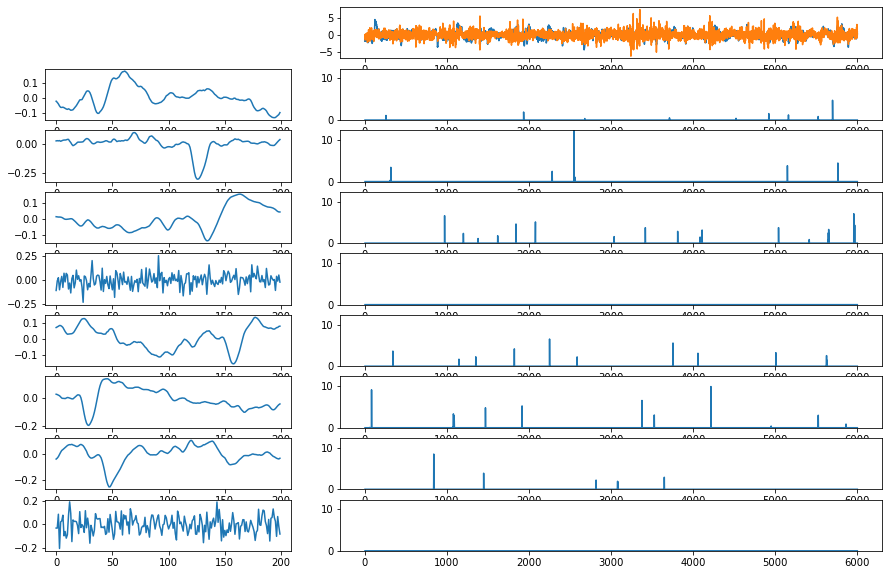

In [16]:
plot_CDL(
    signal, atleast_2d(sparse_codes), atleast_2d(dict_learning.squeeze())
)

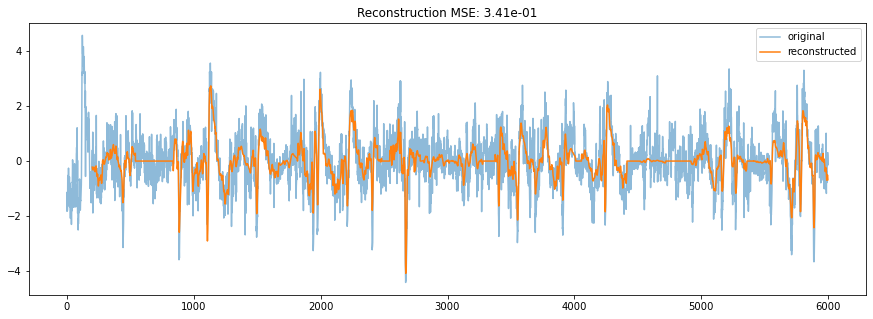

In [17]:
# Reconstruction with the dictionary and the sparse codes
reconstruction = np.stack(
    [
        np.convolve(code, atom, mode="valid")
        for (code, atom) in zip(
            atleast_2d(sparse_codes).T, atleast_2d(dict_learning.squeeze()).T
        )
    ],
    axis=0,
)

offset = atom_length - 1

fig, ax = fig_ax()
tt = np.arange(signal.shape[0])
ax.plot(tt, signal[:,0], label="original", alpha=0.5)
ax.plot(tt[offset:], reconstruction.sum(axis=0), label="reconstructed")
ax.set_title(
    f"Reconstruction MSE: {np.mean((signal[offset :,0].flatten() - reconstruction.sum(axis=0))**2):.2e}"
)
_ = plt.legend()

### Using CDL for classification

In [20]:
# parameters
n_atoms = 8
atom_length = 200
penalty = 4 #6

# Random number generator
rng = np.random.RandomState(seed=123)

In [21]:
# Dictionary learning 
dict_learning = []
for label in range(1,6): # 5 labels
    # Select a signal having the given label
    signal = get_training_signal(sample, label)
    for dim in range(2): # 2 dimensions
        # learn dictionary
        dict_learning.append(learn_dict(atleast_2d(signal[:,dim]), atom_length, n_atoms, rng, penalty))

In [22]:
MSE = np.zeros((10, len(sample['labels'])))

for i, dl in enumerate(dict_learning):
    # retrieve channel corresponding to a dictionnary
    channel = i%2 
    # compute MSE for all the reconstruction of each sample
    for k in tqdm(range(len(sample['labels']))):
        signal = atleast_2d(scale(sample['data'][k,channel,:].T))
        codes = learn_codes(
            signal=signal, atom_dictionary=dl, penalty=penalty
        )
        error = compute_error(
            signal=signal, atom_dictionary=dl, codes=codes
        )
        MSE[i,k] = error

In [51]:
# sum MSE of both channels
score = MSE[np.arange(0,10,2)] + MSE[np.arange(1,10,2)]
# get prediction
predicted_labels = np.argmin(score,axis=0)+1
# print results
print("=== PERFORMANCES ===")
print('Accuracy: %.3f' % accuracy_score(sample['labels'], predicted_labels))
print('Average recall: %.3f' % recall_score(sample['labels'], predicted_labels, average='macro'))
print('Average precision: %.3f' % precision_score(sample['labels'], predicted_labels, average='macro'))

=== PERFORMANCES ===
Accuracy: 0.475
Average recall: 0.424
Average precision: 0.549


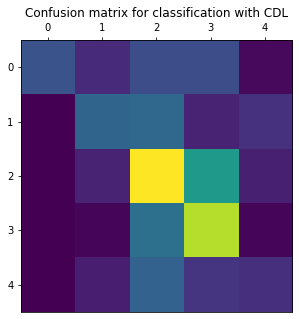

In [55]:
cm = confusion_matrix(sample['labels'], predicted_labels, labels=np.arange(1,6))

fig = plt.figure(figsize=(5,5))
plt.title("Confusion matrix for classification with CDL")
axes = plt.gca()
plt.imshow(cm)
axes.xaxis.tick_top()
plt.show()